# Weak Supervision for data labelling using Snorkel

## Goal:

The main goal of this notebook is to demonstrate the use of semi supervised data labelling technique to label news about cleantech in accordance with UN Sustainable Goal 13 - Climate Action and 7 - Affordable and Clean Energy. 


In [1]:
# Import packages
import pandas as pd
import numpy as np

In [37]:
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import LabelModel
from snorkel.labeling.model import MajorityLabelVoter

In [3]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [4]:
# import internal modules
from scripts import calc_count_stats, gensim_model, snorkel_helpers, cleantech_stats

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Investigating Techcrunch Data

**Dataset**: techcrunch news article snapshot of 2011-2021. All copyright belongs to TechCrunch.  

Columns:
 - **date_gmt(datetime)** - published date
 - **link(string)** - source article link
 - **clean_text (string)** - news article summary, cancatenated with header
 - **author(digit)** - author id
 - **categories (string)** - article categories ids
 - **tags (string)** - tag ids assigned to the article
 - **author(digit)** - the reporter id who is the author of the news article
 - **_embedded(string)** - string with dictionaries that contain some descriptive info on authors, categories and tags

In [6]:
df = pd.read_csv('data/techcrunch_source.csv')

In [7]:
# filter data for snorkel analysis
data = df[[ 'date_gmt', 'link', 'clean_text', 'author', 'categories', 'tags', 'answer', '_embedded' ]].copy()

In [8]:
# fill nan with empty array for further processing
data.fillna({'tags':'[]', 'categories':'[]'}, inplace=True)

#### Tags and Categories

Techcrunch news are categorized with categories and tags. We could use those as an input to Snorkel labelling model. To do so, we need to analyze available tags, categories and their dictribution. 

I've analyzed this using tags and categories lists for each post, as well as _embedded object, which contain descriptive information about all entities.

In [9]:
# Analyzing most popular Techcrunch categories
categories_stats = calc_count_stats.generate(data[['categories', '_embedded']], 0)

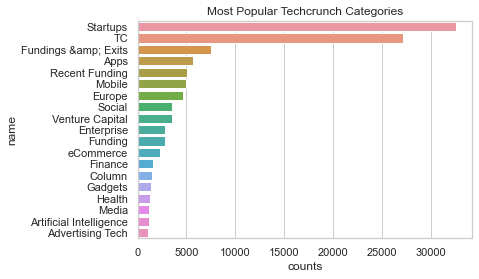

In [10]:
# Generating most popular categories chart
data_categories_chart=categories_stats[categories_stats['counts']>1000]
categories_chart = sns.barplot(
    y="name", 
    x="counts", 
    data= data_categories_chart, 
    order=data_categories_chart.sort_values('counts', ascending=False).name).set(title='Most Popular Techcrunch Categories')

In [11]:
# Analyze most popular techcrunch Tags
tags_stats = calc_count_stats.generate(data[['tags', '_embedded']], 1)


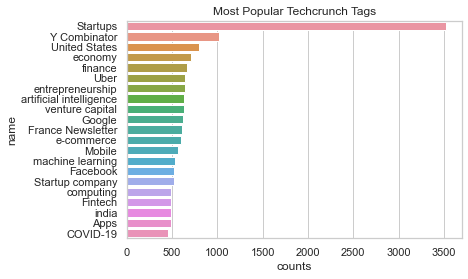

In [13]:
# Generating most popular tags chart
data_tags_chart=tags_stats[tags_stats['counts']>450]
categories_chart = sns.barplot(
    y="name", 
    x="counts", 
    data= data_tags_chart, 
    order=data_tags_chart
    .sort_values('counts', ascending=False).name).set(title='Most Popular Techcrunch Tags')

In [14]:
# Saving the results
tags_stats.to_csv('tags_stats.csv')
categories_stats.to_csv('categories_stats.csv')

## 2. Enriching data for semi-supervised labelling with Gensim Topics Model

I don't know in advance all topics Techcrunch writes about. Gensim will help to use unsupervised Machine Learning Model to get an overview of all topics, which we could use for data labelling as well. 

**Gensim** is a library for unsupervised topic modelling, it divides a whole corpus into a series of topics with similar meaning.  
Here we'll build a topics model using **Latent Dirichlet Allocation** algorithm, and will use it as one of the functions for Snorkel labels model.
I wrote in more details about Gensim in this article - https://dev.to/mariazentsova/topic-modelling-with-gensim-and-spacy-on-startup-news-5ejn

### 2.1 Build Gensim Topics model and assign most likely topic to the chart

In [10]:
# Create a gensim model and return a list of all topics available
topics, data = gensim_model.build_the_model(data)

In [11]:
topics

[(21,
  '0.048*"peer" + 0.047*"care" + 0.042*"health" + 0.041*"healthcare" + 0.040*"patient" + 0.033*"doctor" + 0.033*"debt" + 0.021*"water" + 0.017*"dog" + 0.015*"contractor"'),
 (8,
  '0.087*"car" + 0.023*"launch" + 0.022*"robot" + 0.020*"vehicle" + 0.020*"rocket" + 0.016*"satellite" + 0.014*"knowledge" + 0.014*"engine" + 0.013*"people" + 0.013*"uber"'),
 (4,
  '0.026*"asset" + 0.022*"wallet" + 0.021*"blockchain" + 0.018*"power" + 0.018*"exchange" + 0.017*"energy" + 0.016*"battery" + 0.014*"fuel" + 0.014*"cryptocurrency" + 0.014*"spotify"'),
 (0,
  '0.056*"card" + 0.053*"bank" + 0.051*"credit" + 0.049*"account" + 0.035*"payment" + 0.032*"fintech" + 0.031*"money" + 0.026*"banking" + 0.023*"company" + 0.022*"service"'),
 (3,
  '0.032*"ticket" + 0.026*"estate" + 0.021*"place" + 0.021*"voice" + 0.019*"pitch" + 0.017*"map" + 0.016*"week" + 0.016*"art" + 0.015*"pm" + 0.015*"home"'),
 (2,
  '0.056*"company" + 0.054*"datum" + 0.045*"customer" + 0.042*"business" + 0.025*"product" + 0.022*"pla

In [12]:
# Dataset, enriched with the Gensim Label
data.head()

,date_gmt,link,clean_text,author,categories,tags,answer,_embedded,lemmas,gensim_topic
0,2017-06-16T17:29:43,https://techcrunch.com/2017/06/16/startup-school/,1500+ startups graduate Y Combinator’s first ...,1603003,"[449557102, 20429, 17396]",[66455],NaN,"{'authors': [{'id': 1603003, 'name': 'Josh Con...","[startup, graduate, today, world, startup, dem...",1
1,2012-05-01T11:30:55,https://techcrunch.com/2012/05/01/the-adsense-...,AdSense For Local Commerce Signpost Raises $3...,2414667,"[20429, 17396]","[173267257, 584618]",NaN,"{'authors': [{'id': 2414667, 'name': 'Sarah Pe...","[advertising, startup, partner, round, morning...",17
2,2013-05-07T14:33:56,https://techcrunch.com/2013/05/07/ambient-loca...,"Ambient Location Didn’t Work, So Business Net...",2414667,"[449557102, 449557028, 3457, 20429, 17396]","[110844, 36381, 7480, 80962, 27138, 7426, 3494...",NaN,"{'authors': [{'id': 2414667, 'name': 'Sarah Pe...","[location, craze, app, intent, people, friend,...",11
3,2013-02-26T15:59:37,https://techcrunch.com/2013/02/26/angry-birds-...,"Angry Birds Toons , Rovio’s New Cartoon Serie...",24986667,"[449557028, 20429, 17396]","[28725223, 149731803, 4092295]",NaN,"{'authors': [{'id': 24986667, 'name': 'Matt Bu...","[bouncy, existence, cartoon, series, detail, 1...",6
4,2016-11-16T04:53:33,https://techcrunch.com/2016/11/15/light-phone-...,Anti-smartphone Light Phone runs into delays....,170861,"[449557086, 449557028, 20429, 17396]","[609795, 344761, 449556032, 449556031]",NaN,"{'authors': [{'id': 2217712, 'name': 'Haje Jan...","[run, delay, people, bit, day, project, respit...",20


In [13]:
# Save the enriched data
data.to_csv('result/techcrunch_enriched_for_snorkel.csv', index=False)

In [7]:
data = pd.read_csv('result/techcrunch_enriched_for_snorkel.csv')

### 2.2 Print most common topics

In [15]:
# Count topics occurance
gensim_topics_stats = data['gensim_topic'].value_counts().rename_axis('topic').reset_index(name='counts')

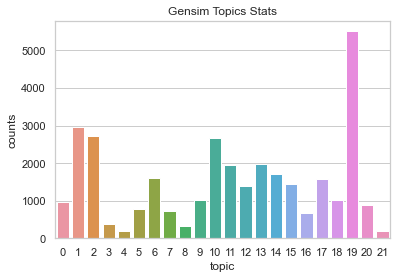

In [16]:
# gensim topics chart
gensim_topics_chart = sns.barplot(y='counts', x='topic', data = gensim_topics_stats).set(title='Gensim Topics Stats')

##### Now, when we have topics, time to divide a dataset into train and test

In [8]:
# test_df has gold, manually assigned labels
# train_df will be used as an input to snorkel for semi supervised labels assignment
train_df =data[data['answer'].isna()].copy()
test_df = data[data['answer'].notna()].copy()

In [9]:
test_df[test_df['answer']=='accept']

,date_gmt,link,clean_text,author,categories,tags,answer,_embedded,lemmas,gensim_topic
373,2021-08-10T16:31:30,https://techcrunch.com/2021/08/10/44-01-secure...,44.01 secures $5M to turn billions of tons of ...,12084691,"[576602978, 60523764, 1102388, 576602979, 4463...","[576908270, 576891112, 576609189, 99066, 60844...",accept,"{'authors': [{'id': 12084691, 'name': 'Devin C...",[],19
521,2021-10-01T23:47:53,https://techcrunch.com/2021/10/01/7-takeaways-...,"7 takeaways from Rivian’s IPO filing. Rivian, ...",133574188,"[449557096, 576602980, 20429, 17396, 2401, 353...","[214074, 576598699, 18477, 576617966, 44955704...",accept,"{'authors': [{'id': 133574188, 'name': 'Kirste...","['takeaway', 'ipo', 'filing', 'automaker', 'co...",19
791,2021-12-01T13:01:18,https://techcrunch.com/2021/12/01/spoiler-aler...,A rind is a terrible thing to waste: Spoiler A...,170861,"[1102388, 576602979, 20429, 17396]","[449551966, 49781465, 576858723, 1465544, 4495...",accept,"{'authors': [{'id': 2217712, 'name': 'Haje Jan...","['rind', 'thing', 'rescue', 'resource', 'proce...",15
792,2021-10-15T17:01:32,https://techcrunch.com/2021/10/15/a-roadmap-fo...,A road map for climate investors. Arvind Gupta...,133574447,"[25515, 447971118, 1102388, 352, 20429, 17396]","[1337, 576914603, 254110, 542, 7334, 1212, 451...",accept,"{'authors': [{'id': 2218751, 'name': 'Arvind G...","['road', 'map', 'climate', 'investor', 'co', '...",14
877,2021-11-05T12:00:35,https://techcrunch.com/2021/11/05/akua-lands-3...,AKUA lands $3.2M to turn kelp into burgers. Th...,133574474,"[11160, 447971118, 576602978, 60523764, 576602...","[576945711, 576611430, 576945712, 576945718, 5...",accept,"{'authors': [{'id': 133574474, 'name': 'Christ...","['kelp', 'burger', 'meat', 'substitute', 'mark...",15
...,...,...,...,...,...,...,...,...,...,...
32301,2021-09-23T11:08:03,https://techcrunch.com/2021/09/23/zola-electri...,Zola Electric closes $90M funding round to sca...,133574425,"[576869656, 576602979, 20429, 17396]","[2214, 449549901, 16895, 576607819, 13570, 449...",accept,"{'authors': [{'id': 133574425, 'name': 'Tage K...","['round', 'technology', 'market', 'million', '...",2
32372,2021-07-15T13:00:39,https://techcrunch.com/2021/07/15/child-transp...,Zūm wants to use its electric school buses to...,133574434,"[20429, 17396, 2401]","[576900589, 576900586, 449557042, 81688]",accept,"{'authors': [{'id': 133574434, 'name': 'Rebecc...","['school', 'bus', 'power', 'grid', 'child', 't...",4
32373,2021-07-29T19:33:33,https://techcrunch.com/2021/07/29/zum-wins-150...,Zūm wins $150M from San Francisco schools to ...,133574434,"[449557096, 20429, 2401]","[576898008, 1413071, 449557042, 81688]",accept,"{'authors': [{'id': 133574434, 'name': 'Rebecc...","['school', 'student', 'transport', 'student', ...",20
32410,2021-08-26T13:00:26,https://techcrunch.com/2021/08/26/firemaps-seed/,"a16z leads investment in Firemaps, a marketpla...",15408904,"[576602978, 60523764, 15986864, 1102388, 57659...","[34024015, 576608473, 576597490, 576912369, 44...",accept,"{'authors': [{'id': 1719192, 'name': 'Danny Cr...","['a16z', 'investment', 'marketplace', 'home', ...",19


In [10]:
len(train_df), len(test_df)

(29648, 3010)

## 3. Labelling data with Snorkel Library 

**Snorkel** is a python library, that allows to use weak supervision to define heuristics using labelling functions. Labelling Function logic is defined by a domain expert and return a data label for a single data point. 

Two main things I will focus on:
 - **maximizing the coverage** of these labelling functions
 - **keeping function independent**, so the conditions don't overlap

In [11]:
## Defining labels
ABSTAIN = -1
CLEANTECH = 0
NOTRELEVANT = 1

### 3.1 Writing abbrevation lookup functions
Functions to filter abbrevations contained in cleantech vs notcleantech news

In [12]:
@labeling_function()
def lf_contains_cleantech_abbrv(x):
    abbrevations_cleantech = ['ev', 'co2', 'pv', 'eVTOL']
   
    for abbrv in abbrevations_cleantech:
        if abbrv.lower() in x.clean_text.lower().split():
            return CLEANTECH
        else:
            return ABSTAIN

In [13]:
@labeling_function()
def lf_contains_notcleantech_abbrv(x):
    abbrevations_notrelevant = ['hr', 'nft', 'crm', 'saas', 'ar', 'vr', '5g',  'defi', 'web3']
    # as these are abbrevations, I will split the text
    for abbrv in abbrevations_notrelevant:
        if abbrv in x.clean_text.lower().split():
            return NOTRELEVANT
        else:
            return ABSTAIN

### 3.2 Writing keywords lookup functions
Functions that take keywords from csv files and return a label

In [14]:
# Load keywords from csv files
cleantech_keywords = pd.read_csv('keywords/Keywords - cleantech_keywords.csv')
notcleantech_keywords = pd.read_csv('keywords/Keywords - notcleantech_keywords.csv')

In [15]:
# prepare functions 
lf_cleantech_keywords = snorkel_helpers.make_keyword_lf(keywords=cleantech_keywords['keyword'].tolist(), label=CLEANTECH, name = 'lf_cleantech_keywords')
lf_notcleantech_keywords = snorkel_helpers.make_keyword_lf(keywords=notcleantech_keywords['keyword'].tolist(), label=NOTRELEVANT, name = 'lf_notcleantech_keywords')

### 3.3 Filter news by cleantech/not cleantech companies mentioned

In [16]:
# Load keywords from csv files
cleantech_startups = pd.read_csv('keywords/Keywords - cleantech_startups.csv')
notcleantech_startups = pd.read_csv('keywords/Keywords - notcleantech_startups.csv')

In [17]:
lf_cleantech_startups = snorkel_helpers.make_keyword_lf(
    keywords=cleantech_startups['startup'].tolist(),
     label=CLEANTECH, 
     name = 'lf_cleantech_startups')
     
lf_notcleantech_startups = snorkel_helpers.make_keyword_lf(
    keywords=notcleantech_startups['startup'].tolist(), 
    label=NOTRELEVANT, 
    name = 'lf_notcleantech_startups')

### 3.4 Filter news by cleantech funds mentioned
Some funds invest mainly in clean tech and green economy. We could filter news, that mention those funds

In [18]:
cleantech_funds = pd.read_csv('keywords/Keywords - cleantech_funds.csv')

In [19]:
lf_cleantech_funds = snorkel_helpers.make_keyword_lf(
    keywords=cleantech_funds['fund'].tolist(),
     label=CLEANTECH, 
     name = 'lf_cleantech_funds')

### 3.5 Filter new by categories

In [20]:
notcleantech_categories = pd.read_csv('keywords/Keywords - notcleantech_categories.csv')
cleantech_categories = pd.read_csv('keywords/Keywords - cleantech_categories.csv')

In [21]:
lf_contains_notcleantech_categories = snorkel_helpers.make_list_lookup_lf(
    keywords=notcleantech_categories.id.tolist(),
     label=NOTRELEVANT, 
     lf_type='categories',
     name = 'lf_contains_notcleantech_categories')


lf_contains_cleantech_categories = snorkel_helpers.make_list_lookup_lf(
    keywords=cleantech_categories.id.tolist(),
     label=CLEANTECH, 
     lf_type='categories',
     name = 'lf_contains_cleantech_categories')
     
     

### 3.6 Filter new by tags

In [22]:
notcleantech_tags = pd.read_csv('keywords/Keywords - notcleantech_tags.csv')
cleantech_tags = pd.read_csv('keywords/Keywords - cleantech_tags.csv')

In [24]:
lf_contains_cleantech_tags = snorkel_helpers.make_list_lookup_lf(
    keywords=cleantech_tags.id.tolist(),
     label=CLEANTECH, 
     lf_type='tags',
     name = 'lf_contains_cleantech_tags')


lf_contains_notcleantech_tags = snorkel_helpers.make_list_lookup_lf(
    keywords=notcleantech_tags.id.tolist(),
     label=NOTRELEVANT, 
     lf_type='tags',
     name = 'lf_contains_notcleantech_tags')

### 3.7 Filter news by author
Some authors on techcrunch focus mostly on cryptocurrency, social networks and other areas. We could use this data point for predictions as well. 

In [25]:
# Contains categories
@labeling_function()
def lf_notcleantech_authors(x):
    notcleantech_authors = [
        2414667, # Sarah Perez - socials
        59254947, #Andrew Keen - education and society
        1851211, #Sophie Alcorn - immigration advice
        521068, # Ron Miller - enterprise solutions
        1048302 # Navin Chaddha - investing philosophy
    ]
    if x.author in notcleantech_authors:
        return NOTRELEVANT
    else:
        return ABSTAIN

### 3.8 Filter news by gensim topic
We have enriched our data using gensim model, and can use this value, as one of the inputs for snorkel labelling

In [26]:
@labeling_function()
def lf_notcleantech_topics(x):
    notcleantech_topics = [
        0, #fintech
        2, #cloud software
        10,  #content
        13 #marketing  
    ]
    if x.gensim_topic in notcleantech_topics:
            return NOTRELEVANT
    else:
        return ABSTAIN

## 4. Predicting the label

In [27]:
lfs = [
   lf_cleantech_keywords,
   lf_notcleantech_keywords,
   lf_contains_cleantech_abbrv,
   lf_contains_notcleantech_abbrv,
   lf_cleantech_startups,
   lf_notcleantech_startups,
   lf_cleantech_funds,
   lf_contains_notcleantech_categories,
   lf_contains_cleantech_categories,
   lf_contains_cleantech_tags,
   lf_contains_notcleantech_tags,
   lf_notcleantech_authors,
   lf_notcleantech_topics
]

In [28]:
applier = PandasLFApplier(lfs=lfs)
# on a train dataframe
L_train = applier.apply(df=train_df)
# on a test dataframe
L_test = applier.apply(df=test_df)

100%|█████████████████████████████████████| 3010/3010 [00:02<00:00, 1334.22it/s]


### 4.1 Analyze Labels Performance

In [29]:
# Analyze functions performance
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_cleantech_keywords,0,[0],0.009107,0.006105,0.004317
lf_notcleantech_keywords,1,[1],0.003002,0.002530,0.000169
lf_contains_cleantech_abbrv,2,[0],0.004385,0.003643,0.002766
lf_contains_notcleantech_abbrv,3,[1],0.011974,0.008635,0.000304
lf_cleantech_startups,4,[],0.000000,0.000000,0.000000
lf_notcleantech_startups,5,[1],0.009309,0.006712,0.000438
lf_cleantech_funds,6,[0],0.000135,0.000135,0.000101
lf_contains_notcleantech_categories,7,[1],0.322147,0.230640,0.004857
lf_contains_cleantech_categories,8,[0],0.008095,0.006105,0.004351
lf_contains_cleantech_tags,9,[0],0.022632,0.015954,0.012682


### 4.2 Training the LabelModel

In [30]:
# Training LabelModel
# produces a set of noise-aware probibalistic training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=100, log_freq=100, seed=123)
preds_train_label = label_model.predict(L=L_train)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|█████████████████████████████████████| 100/100 [00:00<00:00, 326.49epoch/s]
INFO:root:Finished Training


In [31]:
# Get emperical accuracy for each function on validation data
L_valid = applier.apply(test_df)
Y_valid = test_df.answer.map({'reject':1, 'accept':0}).values
LFAnalysis(L_valid, lfs).lf_summary(Y = Y_valid)

100%|█████████████████████████████████████| 3010/3010 [00:02<00:00, 1331.40it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_cleantech_keywords,0,[0],0.021927,0.018605,0.010299,32,34,0.484848
lf_notcleantech_keywords,1,[1],0.001661,0.001661,0.000000,5,0,1.000000
lf_contains_cleantech_abbrv,2,[0],0.019269,0.014618,0.007641,36,22,0.620690
lf_contains_notcleantech_abbrv,3,[1],0.023256,0.021595,0.000997,69,1,0.985714
lf_cleantech_startups,4,[],0.000000,0.000000,0.000000,0,0,0.000000
lf_notcleantech_startups,5,[1],0.011296,0.007973,0.001329,33,1,0.970588
lf_cleantech_funds,6,[],0.000000,0.000000,0.000000,0,0,0.000000
lf_contains_notcleantech_categories,7,[1],0.273422,0.246512,0.008970,821,2,0.997570
lf_contains_cleantech_categories,8,[0],0.025249,0.019269,0.008306,62,14,0.815789
lf_contains_cleantech_tags,9,[0],0.074751,0.052824,0.031561,127,98,0.564444


In [32]:
# Return the vector of learned LF weights for combining LFs
label_model.get_weights()

/Users/kirillzentsov/Library/Caches/pypoetry/virtualenvs/label-with-snorkel-OP3drzL2-py3.8/lib/python3.8/site-packages/snorkel/labeling/model/label_model.py:387: RuntimeWarning: divide by zero encountered in true_divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


array([0.84711834, 0.75575622, 0.61188701, 0.60409518, 1.        ,
       0.54136554, 0.73763664, 0.73916468, 0.81782718, 0.7485765 ,
       0.74439848, 0.88261893, 0.62038156])

In [42]:
# Calculate metrics for LabelModel
metrics= label_model.score(L_valid, Y_valid, metrics=["accuracy", 'recall', 'precision'])
metrics

{'accuracy': 0.949896480331263,
 'recall': 0.9518716577540107,
 'precision': 0.9939506747324337}

### 4.3 Training Majority Label Model

In [43]:
# Training Majority Label Model
majority_model = MajorityLabelVoter()
preds_train_majority = majority_model.predict(L=L_train)

# Calculate metrics for MajorityLabelVoter model
# takes the most popular label from functions on per datapoint basis

metrics_majority= majority_model.score(L_valid, Y_valid, metrics=["accuracy", 'recall', 'precision'])
metrics_majority

{'accuracy': 0.9642096293140179,
 'recall': 0.9668483197093551,
 'precision': 0.9948598130841122}

### Get all predicted cleantech news

In [34]:
train_df["answer"] = preds_train_label.copy()
cleantechs_predicted = train_df[train_df['answer'] == 0]
len(cleantechs_predicted)

824

In [58]:
# Saving cleantech news
cleantechs_predicted.to_csv('result/cleantechs_predicted.csv')

#### Analyze how cleantech coverage changed over the years

In [35]:
dff = cleantech_stats.prepare_sum_stats(train_df, test_df)

<AxesSubplot:xlabel='year', ylabel='count'>

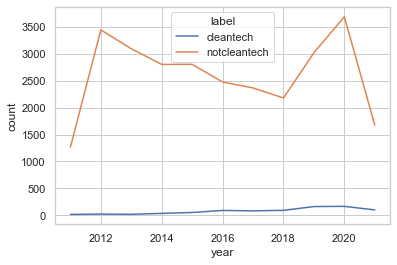

In [36]:
sns.lineplot(data=dff, x='year', y='count', hue='label')

## 5. Improving the result
One of the ways to gradually improve labelling functions is to focus on areas, where they are in conflict or abstain from labelling. 

Let's review all data points, where the model couldn't make a prediction and update our functions accordingly. 

In [54]:
# Filter and investigate data points without the label
no_label = train_df[train_df['answer'] == -1]

In [55]:
len(no_label)

8024

In [56]:
no_label.to_csv('result/no_label.csv')

# References:
- https://www.nature.com/articles/s41467-019-11012-3 
- https://learning.oreilly.com/library/view/practical-weak-supervision/9781492077053/
- https://www.snorkel.org/use-cases/01-spam-tutorial